In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
import cvxpy as cp

class SyntheticControl(BaseEstimator, RegressorMixin):

    def __init__(self,):
        pass

    def fit(self, X, y):

        X, y = check_X_y(X, y)
    
        w = cp.Variable(X.shape[1])
        objective = cp.Minimize(cp.sum_squares(X@w - y))
        
        constraints = [cp.sum(w) == 1, w >= 0]
        
        problem = cp.Problem(objective, constraints)
        
        self.loss_ = problem.solve(verbose=False)
        
        self.X_ = X
        self.y_ = y
        self.w_ = w.value
        
        self.is_fitted_ = True
        return self
        
        
    def predict(self, X):

        check_is_fitted(self)
        X = check_array(X)
        
        return X @ self.w_

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/smoking.csv")

In [4]:
df.head()

,state,year,cigsale,lnincome,beer,age15to24,retprice,california,after_treatment
0,1,1970,89.800003,NaN,NaN,0.178862,39.599998,False,False
1,1,1971,95.400002,NaN,NaN,0.179928,42.700001,False,False
2,1,1972,101.099998,9.498476,NaN,0.180994,42.299999,False,False
3,1,1973,102.900002,9.550107,NaN,0.182060,42.099998,False,False
4,1,1974,108.199997,9.537163,NaN,0.183126,43.099998,False,False


# T-Test

In [5]:
def partition_effect(k, X_pre_co, y_pre_tr, X_post_co, y_post_tr, T0, K, r):
    model = SyntheticControl()
    Hk = ((T0-(r*K))+np.arange((k-1)*r,k*r,1)).astype(int)
    
    model.fit(
        X_pre_co.drop(X_pre_co.index[Hk]),
        y_pre_tr.drop(y_pre_tr.index[Hk]).values.flatten())
    
    y0_hat = model.predict(X_post_co)
    bias = np.mean(y_pre_tr.iloc[Hk].values.flatten() - model.predict(X_pre_co.iloc[Hk]))

    return np.mean(y_post_tr.values.flatten() - y0_hat) - bias

In [6]:
from toolz import partial
from scipy.stats import t

def sc_ttest(df, y_col, unit_col, time_col, treatment_col, post_col, K=3, alpha=0.05):
    T0 = len(df.query(f"~{post_col}")[time_col].unique())
    T1 = len(df.query(f"{post_col}")[time_col].unique())
    
    r = min(np.floor(T0/K), T1)
    
    y_pre_tr = df.query(f"~{post_col} & {treatment_col}").pivot(time_col, unit_col, y_col)
    X_pre_co = df.query(f"~{post_col} & ~{treatment_col}").pivot(time_col, unit_col, y_col)
    
    y_post_tr = df.query(f"{post_col} & {treatment_col}").pivot(time_col, unit_col, y_col)
    X_post_co = df.query(f"{post_col} & ~{treatment_col}").pivot(time_col, unit_col, y_col)
    
    effect_fn = partial(partition_effect,
                        X_pre_co=X_pre_co,
                        y_pre_tr=y_pre_tr,
                        X_post_co=X_post_co,
                        y_post_tr=y_post_tr,
                        T0=T0,
                        K=K,
                        r=r)
    
    atts =  [effect_fn(k) for k in range(K)]
    tau = np.mean(atts)
    se = np.sqrt(1+((K*r)/T1))*np.std(atts, ddof=1)/np.sqrt(K)
    
    return {
        "tau_hat": tau,
        "se_hat": se,
        "t_hat": tau/se,
        "lb": tau - t.ppf(1-alpha/2, K-1)*se,
        "up": tau + t.ppf(1-alpha/2, K-1)*se
    }

In [7]:
sc_ttest(df, y_col="cigsale", unit_col="state", time_col="year", treatment_col="california", post_col="after_treatment")

{'tau_hat': -19.07622052514913,
 'se_hat': 0.1895190354300751,
 't_hat': -100.6559603992259,
 'lb': -19.891655120312492,
 'up': -18.260785929985765}

# Effect Over Time

In [8]:
post_years = df.query("after_treatment")["year"].unique()

t_test_fn = partial(sc_ttest,
                    y_col="cigsale",
                    unit_col="state",
                    time_col="year",
                    treatment_col="california",
                    post_col="after_treatment")

result = pd.DataFrame([dict(year=yr, **t_test_fn(df.query(f"~after_treatment|year=={yr}")))
                       for yr in post_years])

result

,year,tau_hat,se_hat,t_hat,lb,up
0,1989,-6.940955,2.719541,-2.552252,-18.642195,4.760285
1,1990,-7.258523,3.648926,-1.989222,-22.958584,8.441538
2,1991,-10.697402,3.589384,-2.980289,-26.141275,4.746472
3,1992,-11.575347,4.027374,-2.874168,-28.903738,5.753044
4,1993,-15.434049,3.888045,-3.969617,-32.162957,1.294859
5,1994,-19.838068,4.106184,-4.831266,-37.505552,-2.170584
6,1995,-20.539134,4.351526,-4.719984,-39.262238,-1.816030
7,1996,-21.854199,3.968625,-5.506743,-38.929816,-4.778583
8,1997,-24.329952,3.505476,-6.940556,-39.412797,-9.247107
9,1998,-20.926173,4.551677,-4.597464,-40.510459,-1.341887


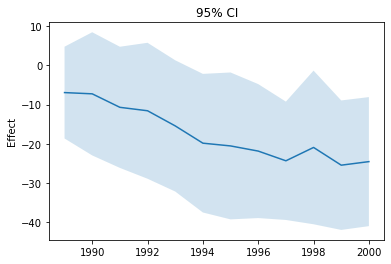

In [9]:
plt.plot(result["year"], result["tau_hat"])
plt.fill_between(result["year"], result["lb"], result["up"], alpha=0.2)
plt.ylabel("Effect")
plt.title("95% CI");